In [1]:
import os
import math
import numpy as np
import preprocessing as prep
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import model
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt


2023-04-20 20:13:50.048141: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('Data/1.csv', index_col=0)
data = df.to_numpy()
train, test = train_test_split(data, test_size=0.2)
train_in, train_out = model.truncate(train, test_len=105, train_len=525)
test_in, test_out = model.truncate(test, test_len=105, train_len=525)
model = model.seq2seq(train_in.shape, train_out.shape, latent_dim=50)

/home/konny135/anaconda3/envs/ML/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [3]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 525, 5)]     0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 50),         11200       ['input_1[0][0]']                
                                 (None, 50),                                                      
                                 (None, 50)]                                                      
                                                                                                  
 batch_normalization (BatchNorm  (None, 50)          200         ['lstm[0][0]']                   
 alization)                                                                                   

In [4]:
history = model.fit(train_in, train_out, epochs=5, batch_size=512, verbose=1)

Epoch 1/5
31/31 [==============================] - 56s 2s/step - loss: 0.1424 - mae: 0.2716
Epoch 2/5
31/31 [==============================] - 50s 2s/step - loss: 0.0679 - mae: 0.1820
Epoch 3/5
31/31 [==============================] - 50s 2s/step - loss: 0.0591 - mae: 0.1674
Epoch 4/5
31/31 [==============================] - 50s 2s/step - loss: 0.0563 - mae: 0.1627
Epoch 5/5
31/31 [==============================] - 50s 2s/step - loss: 0.0550 - mae: 0.1602


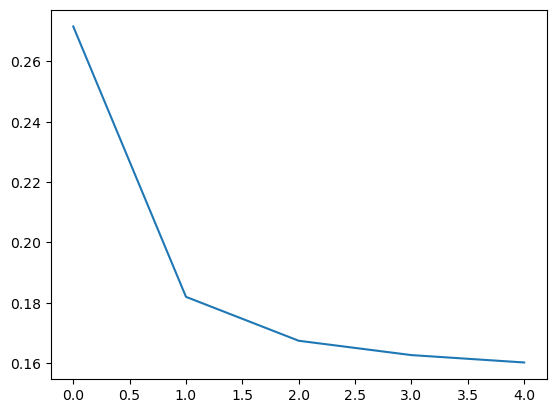

In [5]:
plt.plot(history.history['mae'])

In [6]:
predictions = model.predict(test_in)
mae = np.mean(predictions - test_out)
mse = mae**2
rmse = np.sqrt(mse)
print("The mae for this prediction is: " + str(mae))
print("The mse for this prediction is: " + str(mse))
print("The rmse for this prediction is: " + str(rmse))

109/109 [==============================] - 10s 87ms/step
The mae for this prediction is: -0.009239911322142177
The mse for this prediction is: 8.537596124105121e-05
The rmse for this prediction is: 0.009239911322142177


In [8]:
validation = df[math.ceil( len(df) * 0.8 ):]
df_pred = pd.DataFrame(predictions, columns = ['pred odds', 'pred r1 spread', 'pred r1 pup', 'pred r2 spread', 'pred r2 pup'])
df_pred.index = validation.index
validation = pd.concat([validation,df_pred],axis=1)
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Time')
plt.ylabel('Implied Probabilities')
plt.plot(validation[['avg','pred odds']])
plt.legend(['Measured values', 'Predictions'], loc='lower right')
plt.show()

ValueError: Must pass 2-d input. shape=(3459, 105, 5)